## Module Imports

In [1]:
# pandas for data loading, manipulation etc.
import pandas as pd

# numeric functions
import numpy as np
from scipy import stats
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelling
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor

## Load Data

In [2]:
# Load the data
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')

# ids of full training dataset
id_train = df_train.index    

# ids of full test dataset
id_test = df_test.index

# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test])
df_all.head(5)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
Id                                                                        
1        856       854          0   NaN             3     1Fam       TA   
2       1262         0          0   NaN             3     1Fam       TA   
3        920       866          0   NaN             3     1Fam       TA   
4        961       756          0   NaN             3     1Fam       Gd   
5       1145      1053          0   NaN             4     1Fam       TA   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...   SaleType ScreenPorch  Street  \
Id                                       ...                                  
1            No       706.0         0.0  ...         WD           0    Pave   
2            Gd       978.0         0.0  ...         WD           0    Pave   
3            Mn       486.0         0.0  ...         WD           0    Pave   
4            No       216.0         0.0  ...         WD           0    Pave   
5            Av       655.0         0.0  ...         WD           0    Pave   

    TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
Id                                                                          
1              8       856.0     AllPub          0      2003         2003   
2              6      1262.0     AllPub        298      1976         1976   
3              6       920.0     AllPub          0      2001         2002   
4              7       756.0     AllPub          0      1915         1970   
5              9      1145.0     AllPub        192      2000         2000   

   YrSold  
Id         
1    2008  
2    2007  
3    2008  
4    2006  
5    2008  

[5 rows x 80 columns]

## Columns with NaN Values

In [3]:
# summary of columns with nan values
#SalePrice nans: test data

cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


## Meaningful NaN Values

In [4]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)
    
#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

df_all[cols_fillna].head(5)

PoolQC MiscFeature Alley Fence MasVnrType FireplaceQu GarageQual  \
Id                                                                    
1    None        None  None  None    BrkFace        None         TA   
2    None        None  None  None       None          TA         TA   
3    None        None  None  None    BrkFace          TA         TA   
4    None        None  None  None       None          Gd         TA   
5    None        None  None  None    BrkFace          TA         TA   

   GarageCond GarageFinish GarageType BsmtExposure BsmtCond BsmtQual  \
Id                                                                     
1          TA          RFn     Attchd           No       TA       Gd   
2          TA          RFn     Attchd           Gd       TA       Gd   
3          TA          RFn     Attchd           Mn       TA       Gd   
4          TA          Unf     Detchd           No       Gd       TA   
5          TA          RFn     Attchd           Av       TA       Gd   

   BsmtFinType1 BsmtFinType2  
Id                            
1           GLQ          Unf  
2           ALQ          Unf  
3           GLQ          Unf  
4           ALQ          Unf  
5           GLQ          Unf

## LotFrontage NaN Values

In [5]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

----------------
Intercept: 93.208483254
----------------
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.688922936177
----------------


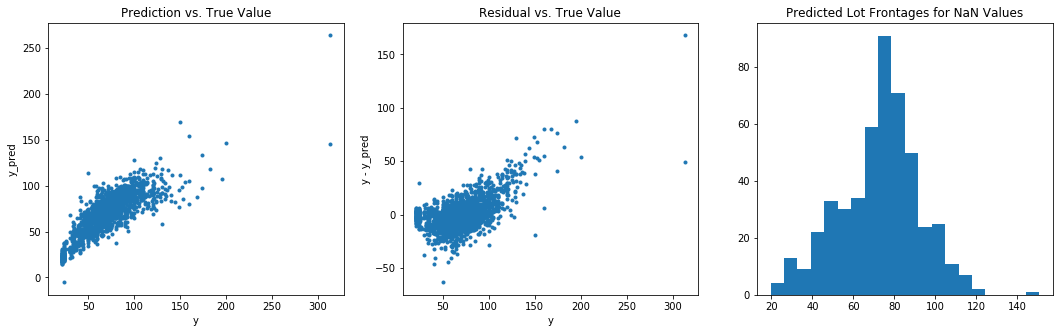

In [6]:
#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

## Remaining NaNs

In [7]:
# Remaining Nan values
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]

print(cols_with_na.sort_values(ascending=False))

rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]
print(rows_with_na.sort_values(ascending=False))

# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64
Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1
dtype: int64


In [8]:
# Now no more NaN values apart from SalePrice in test data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

## Basement Finish Types

In [9]:
# create separate columns for area of each possible
# basement finish type
bsmt_fin_cols = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
                 'BsmtRec','BsmtLwQ','BsmtUnf']

for col in bsmt_fin_cols:
    # initialise as columns of zeros
    df_all[col] = 0

# assign old UnfSF column to the new one
df_all['BsmtUnf'] = df_all['BsmtUnfSF']

# fill remaining finish type columns
for row in df_all.index:
    fin1 = df_all.loc[row,'BsmtFinType1']
    if (fin1!='None') and (fin1!='Unf'):
        # add area (SF) to appropriate column
        df_all.loc[row,'Bsmt'+fin1] += df_all.loc[row,'BsmtFinSF1']
        
    fin2 = df_all.loc[row,'BsmtFinType2']
    if (fin2!='None') and (fin2!='Unf'):
        df_all.loc[row,'Bsmt'+fin2] += df_all.loc[row,'BsmtFinSF2']

# normalise new columns by TotalBsmtSF
for col in bsmt_fin_cols:
    df_all.loc[df_all['TotalBsmtSF']>0, col] = df_all.loc[df_all['TotalBsmtSF']>0,col] / df_all['TotalBsmtSF'] 

#plot to demonstrate the effect of the new feature
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.regplot(df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'BsmtUnfSF'],
            df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'SalePrice'],
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'r'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf SF')
plt.title('Before')

plt.subplot(1,2,2)
sns.regplot(df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'BsmtUnf'],
            df_all.loc[(df_all['BsmtUnf']>0) & (df_all['BsmtUnf']<1), 'SalePrice'],            
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'b'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf Fraction')
plt.title('After')

# remove initial BsmtFin columns
df_all.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2',
             'BsmtFinSF2','BsmtUnfSF'], axis=1, inplace=True)

df_all[bsmt_fin_cols].head(5)



BsmtGLQ   BsmtALQ  BsmtBLQ  BsmtRec  BsmtLwQ   BsmtUnf
Id                                                         
1   0.824766  0.000000      0.0      0.0      0.0  0.175234
2   0.000000  0.774960      0.0      0.0      0.0  0.225040
3   0.528261  0.000000      0.0      0.0      0.0  0.471739
4   0.000000  0.285714      0.0      0.0      0.0  0.714286
5   0.572052  0.000000      0.0      0.0      0.0  0.427948

## 1st and 2nd Floor Area

In [10]:
df_all['LowQualFin'] = df_all['LowQualFinSF']/df_all['GrLivArea']
df_all['1stFlr'] = df_all['1stFlrSF']/df_all['GrLivArea']
df_all['2ndFlr'] = df_all['2ndFlrSF']/df_all['GrLivArea']

df_all.drop(['LowQualFinSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

## Categorical Features with Meaningful Ordering

In [11]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

display(df_all[cols_ExGd].head(5))    

# Remaining columns
df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

ExterQual  ExterCond  BsmtQual  BsmtCond  HeatingQC  KitchenQual  \
Id                                                                     
1           4          3         4         3          5            4   
2           3          3         4         3          5            3   
3           4          3         4         3          5            4   
4           3          3         3         4          4            4   
5           4          3         4         3          5            4   

    FireplaceQu  GarageQual  GarageCond  PoolQC  
Id                                               
1             0           3           3       0  
2             3           3           3       0  
3             3           3           3       0  
4             4           3           3       0  
5             3           3           3       0

## Dealing with Zeros

In [12]:
# fraction of zeros in each column
frac_zeros = ((df_all==0).sum()/len(df_all))

# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

#very few properties with Pool or 3SsnPorch
#replace columns with binary indicator
df_all['Pool'] = (df_all['PoolQC']>0).astype(int)
df_all['3SsnPorch'] = (df_all['3SsnPorch']>0).astype(int)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

# 'half' bathrooms - add half value to 'full' bathrooms
df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

# create additional dummy variable for
# continuous variables with a lot of zeros
dummy_cols = ['LowQualFin','2ndFlr',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces',             
              'BsmtGLQ','BsmtALQ','BsmtBLQ','BsmtRec',
              'BsmtLwQ','BsmtUnf','TotalBsmtSF']

for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

frac_zeros  n_unique  xs_zeros
LowQualFin       0.986297        39  0.960656
3SsnPorch        0.987324        31  0.955066
MiscVal          0.964714        38  0.938398
PoolArea         0.995546        14  0.924118
BsmtLwQ          0.917437       225  0.912993
ScreenPorch      0.912299       121  0.904034
BsmtBLQ          0.885235       322  0.882129
BsmtRec          0.865365       362  0.862602
EnclosedPorch    0.842754       183  0.837290
BsmtALQ          0.835218       456  0.833025
PoolQC           0.996574         4  0.746574
BsmtGLQ          0.697499       823  0.696284
BsmtHalfBath     0.940048         3  0.606715
MasVnrArea       0.603289       444  0.601037
2ndFlr           0.571429      1040  0.570467
WoodDeckSF       0.521754       379  0.519116
OpenPorchSF      0.444673       252  0.440705
BsmtFullBath     0.584789         4  0.334789
FireplaceQu      0.486468         6  0.319801
HalfBath         0.628297         3  0.294964
Fireplaces       0.486468         5  0.286468
BsmtUnf          0.082905      1730  0.082327
GarageArea       0.054128       603  0.052470
TotalBsmtSF      0.027064      1058  0.026119

In [13]:
#PROBLEM OF LOTS OF ZEROS -2ndFlrSF
#####
# mode only using 2ndflrsf
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlr','Has2ndFlr']].dropna())

y = tmp.SalePrice
X = tmp['2ndFlr']

plt.plot(X,y,'.',label='data',alpha=0.5)

lr = LinearRegression()
lr.fit(X.values.reshape(-1, 1),y)
lr_coefs = pd.Series(lr.coef_,index=['Has2ndFlr'])
lr_intercept = lr.intercept_

def regval(flr2ndSF):
    return flr2ndSF*lr_coefs + lr_intercept

plt.plot([0,1],[regval(0),regval(1)],'b',linewidth=3,label='2ndFlr only')

#####
# model using has2ndflr dummy variable
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlr','Has2ndFlr']].dropna())

y = tmp.SalePrice

X = tmp.drop('SalePrice',axis=1)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF,has2nd):
    return flr2ndSF*lr_coefs['2ndFlr'] + has2nd*lr_coefs['Has2ndFlr'] + lr_intercept

plt.plot([0,0.02,1],[regval(0,0),regval(0,1),regval(1,1)],'r',linewidth=3,label='with Has2ndFlr')

plt.legend()
plt.xlabel('2ndFlr')
plt.ylabel('SalePrice');

## Identify Types of Features

In [14]:
# extract names of numeric columns
dtypes = df_all.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

# MSubClass should be treated as categorical
cols_numeric.remove('MSSubClass')

# choose any numeric column with less than 13 values to be
# "discrete". 13 chosen to include months of the year.
# other columns "continuous"
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df_all[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous, and',
      len(cols_discrete),'are discrete.')

69 numeric columns, of which 25 are continuous, and 44 are discrete.


In [15]:
# extract names of categorical columns
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

for col in cols_categ:
    df_all[col] = df_all[col].astype('category')
    
print(len(cols_categ),'categorical columns.')

25 categorical columns.


## Distribution of SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


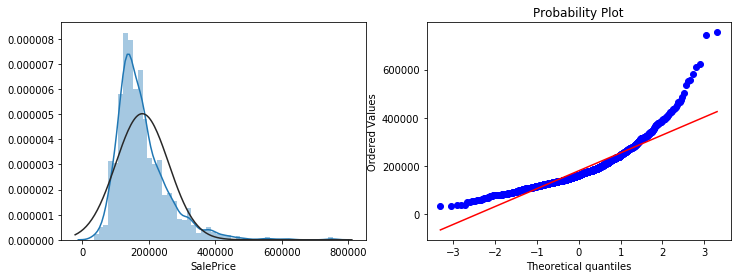

In [16]:
print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_all.SalePrice.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(df_all.SalePrice.dropna(), plot=plt)

## Log Transform SalePrice

In [17]:
#Log Transform SalePrice to improve normality
sp = df_all.SalePrice
df_all.SalePrice = np.log1p(sp)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)

## Distribution of SalePrice in Categorical Variables

In [18]:
# plot categorical variables
fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

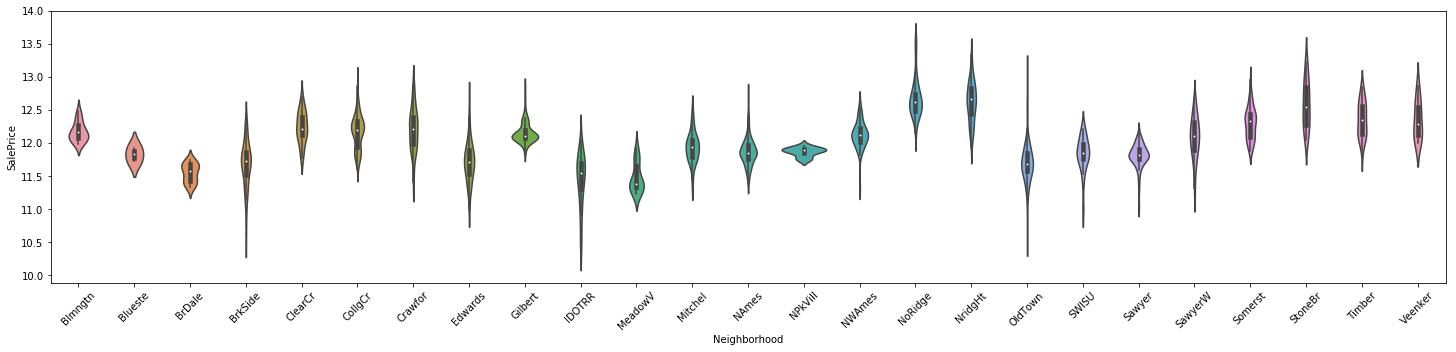

In [19]:
# few bigger plots for features with two many categories to see above

#Neighbourhood
plt.figure(figsize=(25,5))
sns.violinplot(x='Neighborhood',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

#Exterior1st
plt.figure(figsize=(25,5))
sns.violinplot(x='Exterior1st',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

In [78]:
encoding = df_all.groupby('Exterior1st').SalePrice.mean()

vals = df_all.Exterior1st

#vals.replace(encoding)
encoding

Exterior1st
AsbShng    11.524525
AsphShn    11.512935
BrkComm    11.158302
BrkFace    12.088146
CBlock     11.561725
CemntBd    12.204928
HdBoard    11.951905
ImStucc    12.476104
MetalSd    11.859775
Plywood    12.041224
Stone      12.456540
Stucco     11.891999
VinylSd    12.205878
Wd Sdng    11.838514
WdShing    11.844549
Name: SalePrice, dtype: float64

## Significance of Categorical Features for SalePrice

In [20]:
# anova test to check significance of variation between groups
def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df_all[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of house (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p
        

In [21]:
# check significance of categorical variables on SalePrice
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

Neighborhood     4.041201e-243
GarageType       8.430356e-125
MSSubClass       5.097264e-115
Foundation       1.350599e-111
MasVnrType        1.669801e-65
MSZoning          1.021737e-59
Exterior1st       1.053089e-53
Exterior2nd       2.429749e-49
SaleCondition     1.689524e-41
SaleType          5.496893e-36
PavedDrive        1.091245e-31
Electrical        6.082296e-31
HouseStyle        1.636014e-30
Fence             6.560268e-13
RoofStyle         1.705634e-12
BldgType          3.436708e-12
Condition1        1.173445e-10
Alley             1.358127e-09
Heating           2.484634e-09
LandContour       3.086154e-08
LotConfig         6.214548e-07
RoofMatl          4.504077e-04
MiscFeature       6.060004e-03
Condition2        1.382043e-02
Street            2.837965e-02
dtype: float64

## Distribution of Numeric Variables and Effect on SalePrice

In [22]:
# plot numeric values

fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df_all, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna() , fit=stats.norm)
    plt.xlabel(col)

## Distribution of SalePrice in Discrete Numeric Features

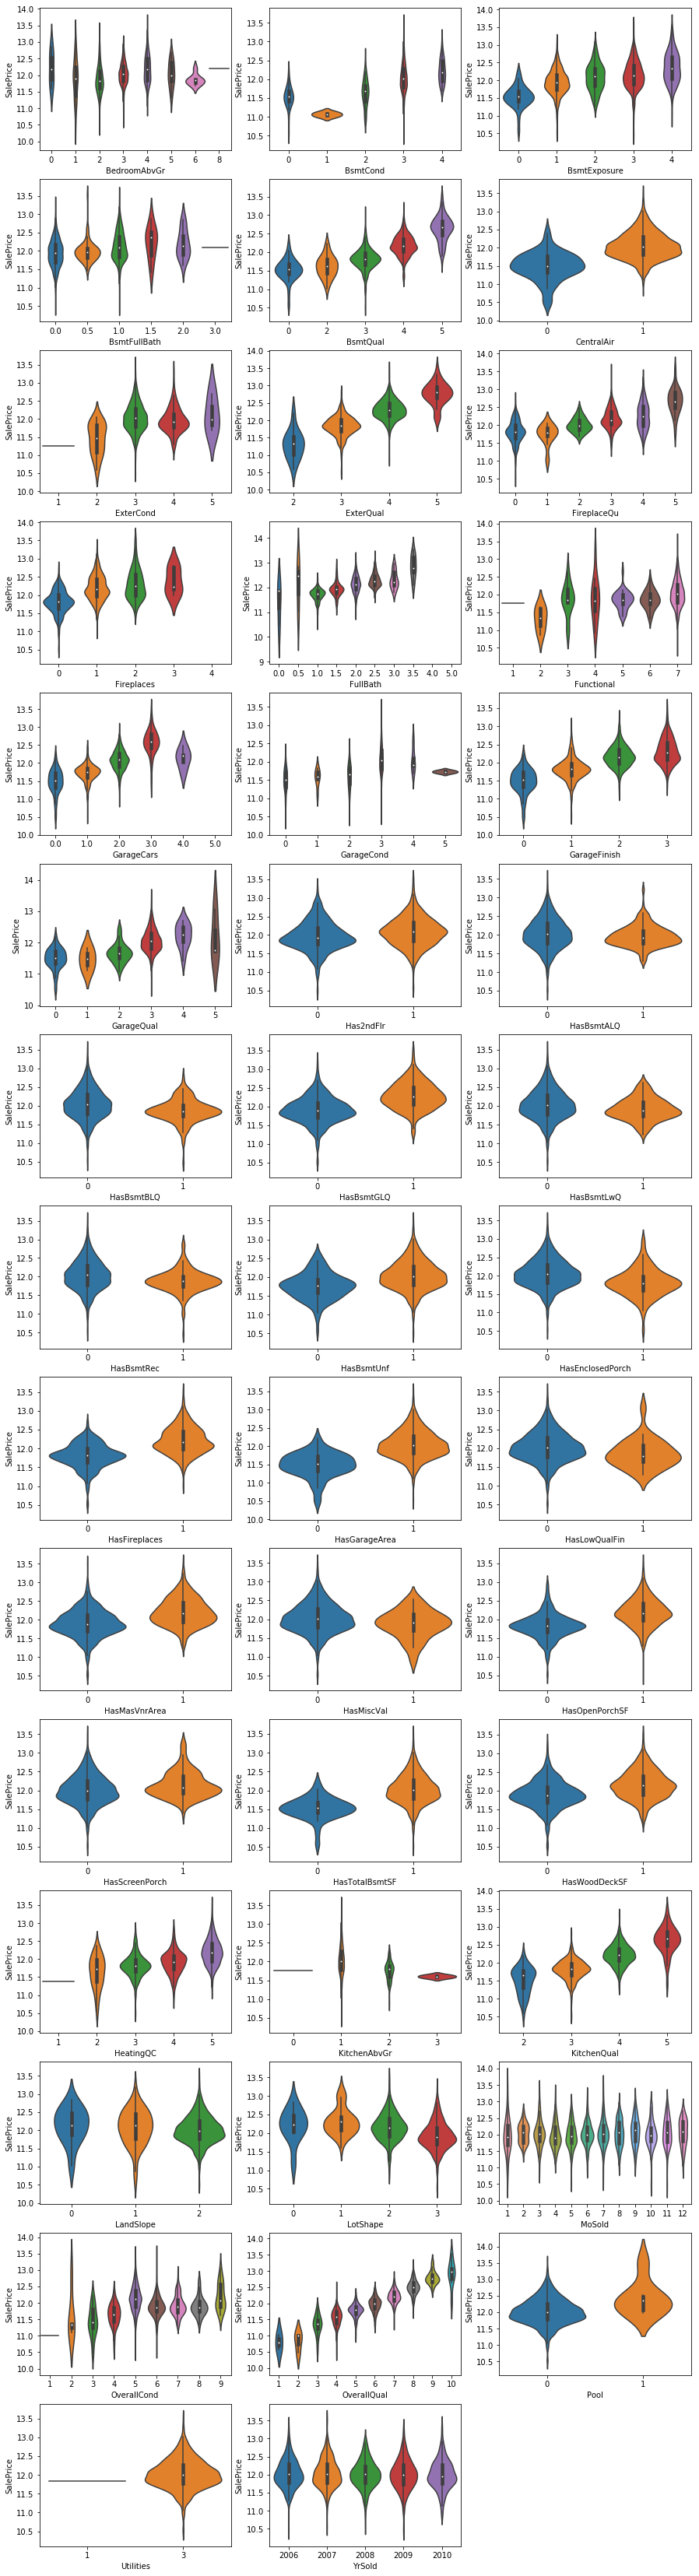

In [23]:
# numeric columns with few values
fcols = 3
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

## Significance of Discrete Numeric Features for SalePrice

In [24]:
p_col = dict()

for col in cols_discrete:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

OverallQual          0.000000e+00
GarageCars          5.536810e-211
ExterQual           6.930372e-195
BsmtQual            2.029970e-188
KitchenQual         4.438817e-187
FullBath            3.732479e-167
GarageFinish        4.058066e-151
FireplaceQu         6.961918e-115
HasFireplaces        1.688491e-97
Fireplaces           7.485284e-97
HeatingQC            1.614912e-82
HasOpenPorchSF       2.024691e-73
HasBsmtGLQ           3.827653e-69
OverallCond          9.272106e-53
HasMasVnrArea        5.245889e-52
GarageCond           2.509004e-47
BsmtExposure         2.590394e-47
GarageQual           6.070436e-46
CentralAir           9.859878e-44
HasGarageArea        8.413969e-37
HasWoodDeckSF        3.391195e-36
LotShape             7.856720e-29
BsmtCond             1.492992e-27
BedroomAbvGr         2.473739e-20
BsmtFullBath         2.301507e-17
HasEnclosedPorch     5.906127e-17
HasTotalBsmtSF       1.370248e-14
ExterCond            6.541282e-14
HasBsmtUnf           1.603679e-13
Has2ndFlr     

## Correlation Between Numeric Features

SalePrice         1.000000
OverallQual       0.809829
GrLivArea         0.731310
GarageCars        0.690711
ExterQual         0.684014
BsmtQual          0.678026
FullBath          0.675455
KitchenQual       0.672849
YearBuilt         0.652682
GarageArea        0.649379
GarageFinish      0.633974
GarageYrBlt       0.612604
TotalBsmtSF       0.602725
YearRemodAdd      0.571159
FireplaceQu       0.537602
TotRmsAbvGrd      0.532586
HasFireplaces     0.525735
Fireplaces        0.519247
HeatingQC         0.491392
HasOpenPorchSF    0.485350
Name: SalePrice, dtype: float64
-----------------
LowQualFin       0.068611
HasLowQualFin    0.068014
HasMiscVal       0.063389
MiscVal          0.062727
Pool             0.058428
LandSlope        0.050310
BsmtUnf          0.036628
YrSold           0.029899
Utilities        0.016710
ExterCond        0.011682
Name: SalePrice, dtype: float64


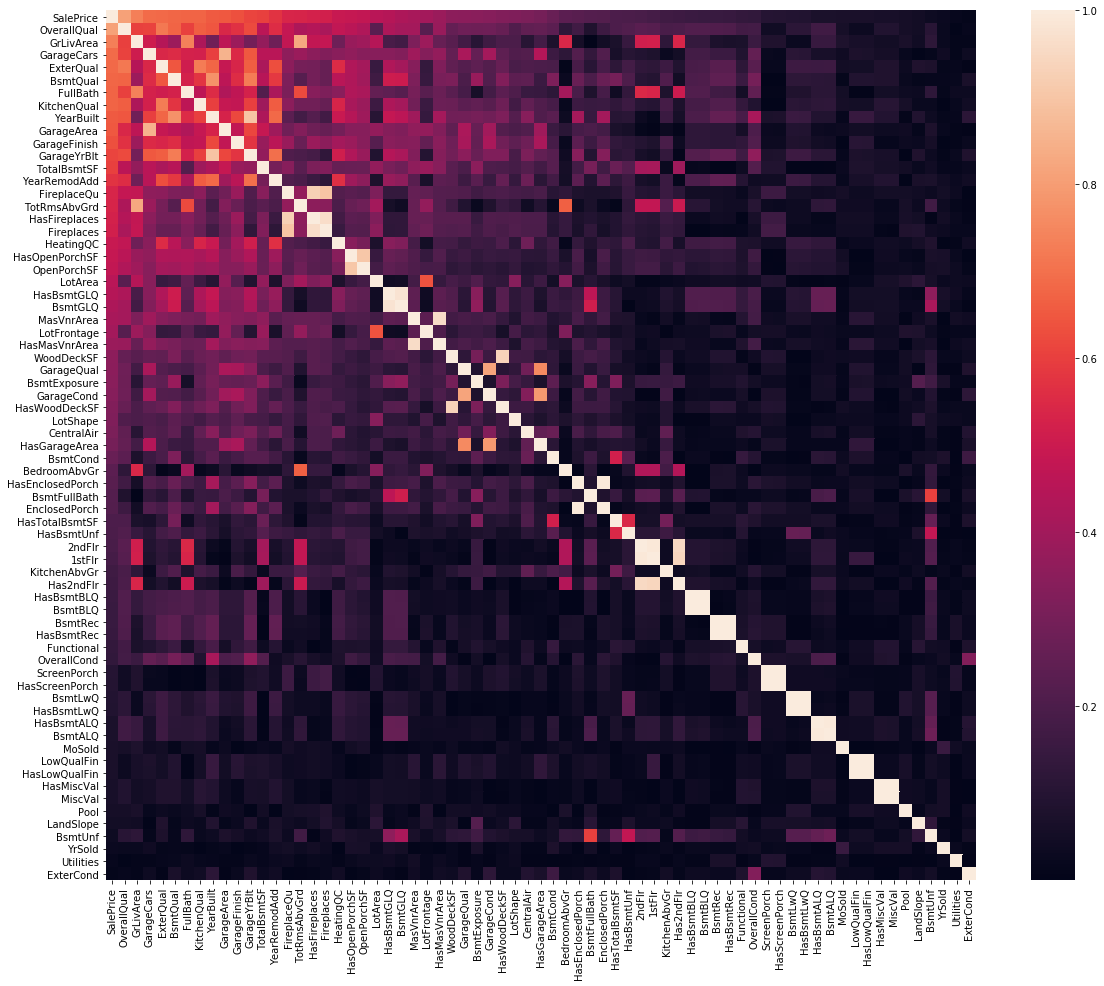

In [25]:
# correlation between numeric variables
df_corr = df_all.loc[id_train, cols_numeric].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice.head(20))
print('-----------------')
print(df_corr.SalePrice.tail(10))

ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

## Collinearity

Many variables strongly correlated, e.g. GarageCars and GarageArea (below).

Kept all features, but feature selection/pca may help some models.

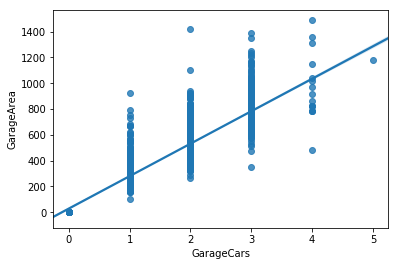

In [26]:
sns.regplot(x='GarageCars',y='GarageArea',data=df_all)

## Normalise Numeric Features

In [27]:
# normalise numeric columns
scale_cols = [col for col in cols_numeric if col!='SalePrice']

df_all[scale_cols] = df_all[scale_cols].apply(scale_minmax,axis=0)

df_all[scale_cols].describe()

BedroomAbvGr     BsmtCond  BsmtExposure  BsmtFullBath     BsmtQual  \
count   2919.000000  2919.000000   2919.000000   2919.000000  2919.000000   
mean       0.357528     0.729616      0.405961      0.153420     0.695512   
std        0.102837     0.143737      0.267506      0.173593     0.181090   
min        0.000000     0.000000      0.000000      0.000000     0.000000   
25%        0.250000     0.750000      0.250000      0.000000     0.600000   
50%        0.375000     0.750000      0.250000      0.000000     0.800000   
75%        0.375000     0.750000      0.500000      0.333333     0.800000   
max        1.000000     1.000000      1.000000      1.000000     1.000000   

        CentralAir  EnclosedPorch    ExterCond    ExterQual  FireplaceQu  \
count  2919.000000    2919.000000  2919.000000  2919.000000  2919.000000   
mean      0.932854       0.022824     0.521411     0.465570     0.353614   
std       0.250318       0.063482     0.093090     0.193431     0.361324   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       1.000000       0.000000     0.500000     0.333333     0.000000   
50%       1.000000       0.000000     0.500000     0.333333     0.200000   
75%       1.000000       0.000000     0.500000     0.666667     0.800000   
max       1.000000       1.000000     1.000000     1.000000     1.000000   

            ...        HasMasVnrArea  HasGarageArea  HasFireplaces  \
count       ...          2919.000000    2919.000000    2919.000000   
mean        ...             0.396711       0.945872       0.513532   
std         ...             0.489299       0.226309       0.499902   
min         ...             0.000000       0.000000       0.000000   
25%         ...             0.000000       1.000000       0.000000   
50%         ...             0.000000       1.000000       1.000000   
75%         ...             1.000000       1.000000       1.000000   
max         ...             1.000000       1.000000       1.000000   

        HasBsmtGLQ   HasBsmtALQ   HasBsmtBLQ   HasBsmtRec   HasBsmtLwQ  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      0.302501     0.164782     0.114765     0.134635     0.082563   
std       0.459420     0.371048     0.318793     0.341392     0.275267   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        HasBsmtUnf  HasTotalBsmtSF  
count  2919.000000     2919.000000  
mean      0.917095        0.972936  
std       0.275786        0.162298  
min       0.000000        0.000000  
25%       1.000000        1.000000  
50%       1.000000        1.000000  
75%       1.000000        1.000000  
max       1.000000        1.000000  

[8 rows x 68 columns]

## Which Numeric Features are Candidates to be Transformed?

In [28]:
#Check effect of Box-Cox transforms on distributions of continuous variables
fcols = 6
frows = len(cols_continuous)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='SalePrice':
        dat = df_all[[var, 'SalePrice']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['SalePrice'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['SalePrice'])[0][1]))

## Box-Cox Transform Suitable Variables

In [29]:
# variables not suitable for box-cox transformation based on above (usually due to excessive zeros)
# NB - have tried BoxCox on SalePrice, but no improvement or slightly worse
# than log transform. Kept log transform to make it simpler to restore SalePrice predictions.
cols_notransform = ['1stFlr','2ndFlr','3SsnPorch','EnclosedPorch',
                    'LowQualFinSF','MasVnrArea','MiscVal','PoolArea',
                    'ScreenPorch','OpenPorchSF','WoodDeckSF','SalePrice',
                    'BsmtGLQ','BsmtALQ','BsmtBLQ','BsmtRec','BsmtLwQ','BsmtUnf']

cols_transform = [col for col in cols_continuous if col not in cols_notransform]

#transform remaining variables
print('Transforming',len(cols_transform),'columns:',cols_transform)

for col in cols_transform:   
    # transform column
    df_all.loc[:,col], _ = stats.boxcox(df_all.loc[:,col]+1)
    
    # renormalise column
    df_all.loc[:,col] = scale_minmax(df_all.loc[:,col])

Transforming 10 columns: ['GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'LowQualFin', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


## Prepare Data for Model Fitting

In [30]:
# select features, encode categoricals, create dataframe for model fitting

# select which features to use (all for now)
model_cols = df_all.columns

# encode categoricals
df_model = pd.get_dummies(df_all[model_cols])

# Rather than including Condition1 and Condition2, or Exterior1st and Exterior2nd
# combine the dummy variables (allowing 2 true values per property)
if ('Condition1' in model_cols) and ('Condition2' in model_cols):
    
    cond_suffix = ['Artery','Feedr','Norm','PosA','PosN','RRAe','RRAn','RRNn']
    
    for suffix in cond_suffix:
        col_cond1 = 'Condition1_'+suffix
        col_cond2 = 'Condition2_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
if ('Exterior1st' in model_cols) and ('Exterior2nd' in model_cols):
    
    # some different strings in Exterior1st and Exterior2nd for same type - rename columns to correct
    df_model.rename(columns={'Exterior2nd_Wd Shng':'Exterior2nd_WdShing',
                             'Exterior2nd_Brk Cmn':'Exterior2nd_BrkComm',
                             'Exterior2nd_CmentBd':'Exterior2nd_CemntBd'},inplace=True)

    ext_suffix = ['AsphShn','BrkComm','BrkFace','CBlock','CemntBd',
                    'HdBoard','ImStucc','MetalSd','Plywood','Stone',
                    'Stucco','VinylSd','Wd Sdng','WdShing','AsbShng']
    
    for suffix in ext_suffix:
        col_cond1 = 'Exterior1st_'+suffix
        col_cond2 = 'Exterior2nd_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
display(df_model.head())

BedroomAbvGr  BsmtCond  BsmtExposure  BsmtFullBath  BsmtQual  CentralAir  \
Id                                                                             
1          0.375      0.75          0.25      0.333333       0.8         1.0   
2          0.375      0.75          1.00      0.166667       0.8         1.0   
3          0.375      0.75          0.50      0.333333       0.8         1.0   
4          0.375      1.00          0.25      0.333333       0.6         1.0   
5          0.500      0.75          0.75      0.333333       0.8         1.0   

    EnclosedPorch  ExterCond  ExterQual  FireplaceQu     ...       \
Id                                                       ...        
1        0.000000        0.5   0.666667          0.0     ...        
2        0.000000        0.5   0.333333          0.6     ...        
3        0.000000        0.5   0.666667          0.6     ...        
4        0.268775        0.5   0.333333          0.8     ...        
5        0.000000        0.5   0.666667          0.6     ...        

    SaleType_CWD  SaleType_Con  SaleType_ConLD  SaleType_ConLI  \
Id                                                               
1              0             0               0               0   
2              0             0               0               0   
3              0             0               0               0   
4              0             0               0               0   
5              0             0               0               0   

    SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  Street_Grvl  \
Id                                                                         
1                0             0             0            1            0   
2                0             0             0            1            0   
3                0             0             0            1            0   
4                0             0             0            1            0   
5                0             0             0            1            0   

    Street_Pave  
Id               
1             1  
2             1  
3             1  
4             1  
5             1  

[5 rows x 237 columns]

## Identify and Remove Outliers

In [31]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [32]:
# function to detect outliers based on the predictions of a model
def remove_outliers(model, X, y, sigma=3, drop=True, verbose=False):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>3].index
    
    # print and plot the results if asked
    if verbose:
        print('R2=',model.score(X,y))
        print('rmse=',rmse(y, y_pred))
        print('---------------------------------------')

        print('mean of residuals:',mean_resid)
        print('std of residuals:',std_resid)
        print('---------------------------------------')
        
        print(len(outliers),'outliers:')
        print(outliers.tolist())
        
        plt.figure(figsize=(15,5))
        ax_131 = plt.subplot(1,3,1)
        plt.plot(y,y_pred,'.')
        plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('y')
        plt.ylabel('y_pred');

        ax_132=plt.subplot(1,3,2)
        plt.plot(y,y-y_pred,'.')
        plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('y')
        plt.ylabel('y - y_pred');

        ax_133=plt.subplot(1,3,3)
        z.plot.hist(bins=50,ax=ax_133)
        z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('z')

    # remove outliers from data if requested
    if drop:
        X = X.drop(outliers)
        y = y.drop(outliers)

    return X,y,outliers

In [33]:
# function to get training samples
def get_training_data():
    # extract training samples
    df_train = df_model.loc[id_train]
    
    # split SalePrice and features
    y = df_train.SalePrice
    X = df_train.drop('SalePrice',axis=1)
    
    return X, y

# extract test data (without SalePrice)
def get_test_data():
    return df_model.loc[id_test].drop('SalePrice',axis=1)

R2= 0.936294340527
rmse= 0.100786383414
---------------------------------------
mean of residuals: -6.594420595581751e-16
std of residuals: 0.10082091703955502
---------------------------------------
20 outliers:
[31, 89, 411, 463, 496, 524, 589, 633, 729, 804, 875, 899, 969, 971, 1182, 1183, 1299, 1325, 1433, 1454]


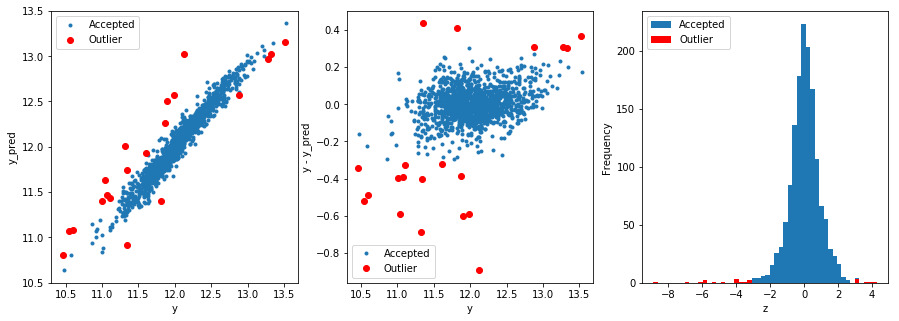

In [34]:
# get training data
X, y = get_training_data()

# find and remove outliers using a Ridge model
X,y,outliers = remove_outliers(Ridge(), X, y, verbose=True)

## First Model - LinearRegression with Regularisation (Ridge)

0.1207 on leaderboard

---------------------------------------
Top 20 contributers to increased price:
---------------------------------------
GrLivArea               0.679832
TotalBsmtSF             0.428956
OverallQual             0.356902
OverallCond             0.311262
LotArea                 0.266424
YearBuilt               0.200438
FullBath                0.178616
Functional              0.171486
Utilities               0.134817
GarageArea              0.130215
OpenPorchSF             0.129672
Neighborhood_StoneBr    0.128913
RoofMatl_WdShngl        0.119696
TotRmsAbvGrd            0.111549
GarageQual              0.110073
WoodDeckSF              0.106399
GarageCars              0.103380
MasVnrArea              0.101155
Pool                    0.098696
Fireplaces              0.098467
dtype: float64
---------------------------------------
Top 20 contributers to decreased price:
---------------------------------------
MSZoning_C (all)        -0.243419
Condition1_RRAe         -0.128675
Neighborhood_Mead

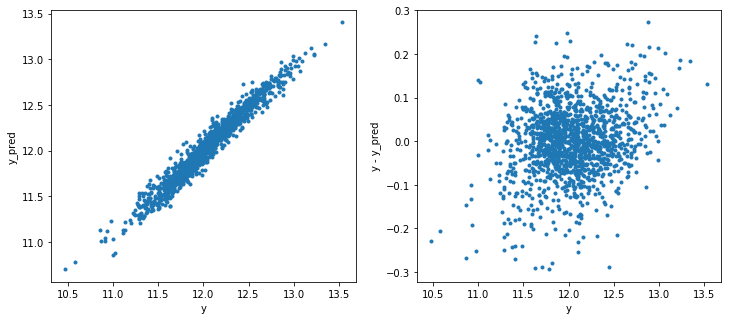

In [35]:
# basic linear model
lr = Ridge()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)

print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(lr_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 20 contributers to decreased price:')
print('---------------------------------------')
print(lr_coefs.sort_values(ascending=True).head(20))
print('---------------------------------------')
print('Intercept: ',lr.intercept_)
print('---------------------------------------')

y_pred = lr.predict(X)
rms_pred = rmse(y, y_pred)

print('R2=',lr.score(X,y))
print('rmse=',rms_pred)
rkfold = RepeatedKFold(n_splits=5, n_repeats=10)
print('cross_val',
      abs(np.mean(cross_val_score(lr, X, y, 
                                  scoring=rmse_scorer, 
                                  cv=rkfold))))
print('---------------------------------------')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y,y_pred,'.')
plt.xlabel('y')
plt.ylabel('y_pred');

plt.subplot(1,2,2)
plt.plot(y,y-y_pred,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');

## Optimise Model Parameters

In [36]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_training_data()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract results and best model from the grid
        grid_results = pd.DataFrame(gsearch.cv_results_)
        model = gsearch.best_estimator_
    else:
        grid_results = []
        
    # re-fit the model with the same parameters, but excluding outliers
    X,y,outliers = remove_outliers(model, X, y)
    model.fit(X,y)

    cv_score = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
    cv_mean = abs(np.mean(cv_score))
    cv_std = np.std(cv_score)
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, model.predict(X)))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(model.predict(X),index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [37]:
# dict to store optimal models
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

## Linear Regression

### Ridge

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   21.2s finished


----------------------
Ridge(alpha=2.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.954710538929
rmse= 0.0822824252251
cross_val: mean= 0.0980136551672 , std= 0.00449028058811


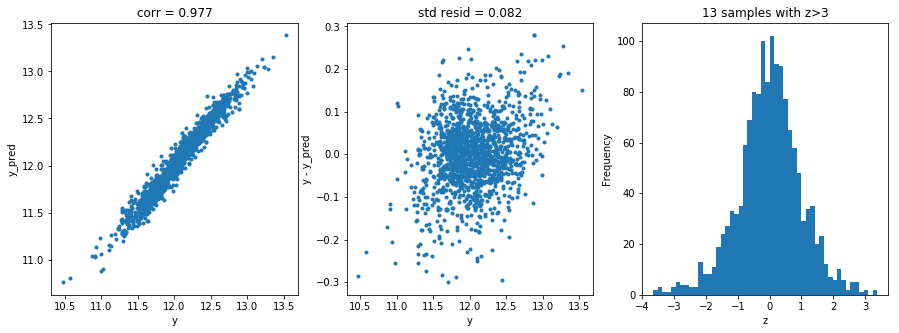

In [38]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### Lasso

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   21.1s finished


----------------------
Lasso(alpha=0.00042000000000000007, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.95034479
rmse= 0.0860405033671
cross_val: mean= 0.0947177477772 , std= 0.00491080085393


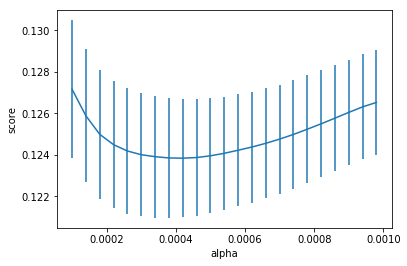

In [39]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### ElasticNet

Fitting 25 folds for each of 90 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:   41.4s finished


----------------------
ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.10000000000000001, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.715292440222
rmse= 0.198933542164
cross_val: mean= 0.201649406625 , std= 0.00836182662822


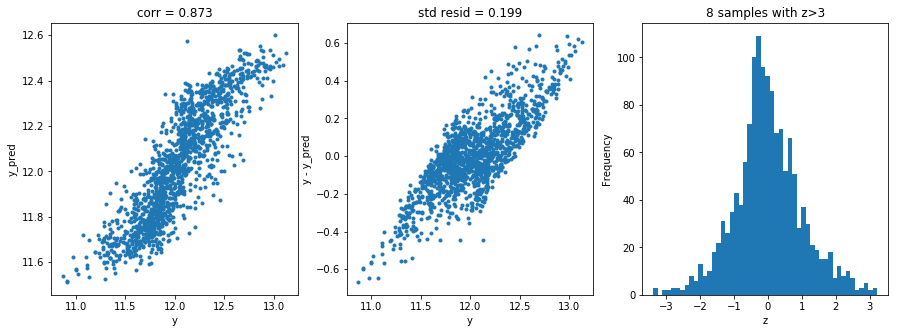

In [40]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(0.1,1.1,0.1),
              'l1_ratio': np.arange(0.1,1.0,0.1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

## SVM

### Linear

In [41]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score');

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   50.8s finished


----------------------
LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
----------------------
score= 0.954772749103
rmse= 0.0826001599326
cross_val: mean= 0.103039830896 , std= 0.00672804827999


### Non-Linear

Fitting 25 folds for each of 30 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:  6.2min finished


----------------------
SVR(C=9, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
----------------------
score= 0.958659829771
rmse= 0.0790641505961
cross_val: mean= 0.104878264049 , std= 0.00397190339801


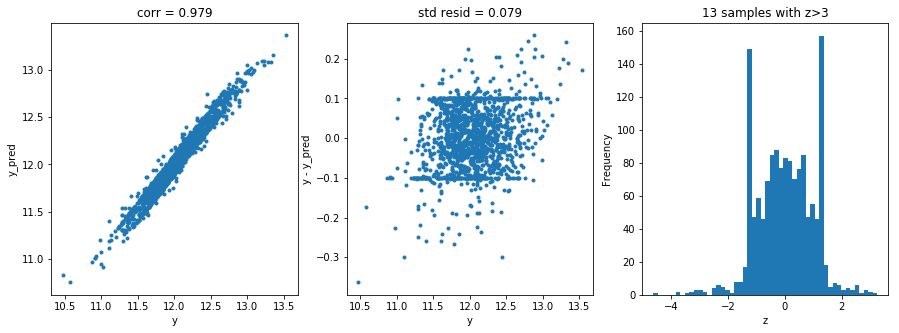

In [42]:
model ='SVR'
opt_models[model] = SVR()

param_grid = {'C':np.arange(1,21,2),
              'kernel':['poly','rbf','sigmoid']}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

## KNeighbors

Fitting 25 folds for each of 8 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.5min finished


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
----------------------
score= 0.863192118157
rmse= 0.140341527131
cross_val: mean= 0.177604672646 , std= 0.00959222602509


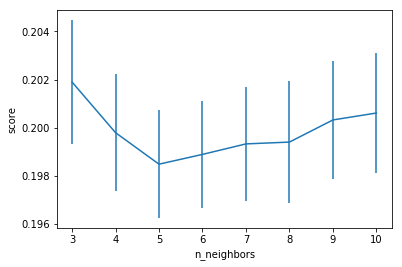

In [43]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('n_neighbors')
plt.ylabel('score');

## Tree-Based

### Random Forest

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.6min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=75, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
----------------------
score= 0.987674310191
rmse= 0.042420858994
cross_val: mean= 0.115802247977 , std= 0.00349075406082


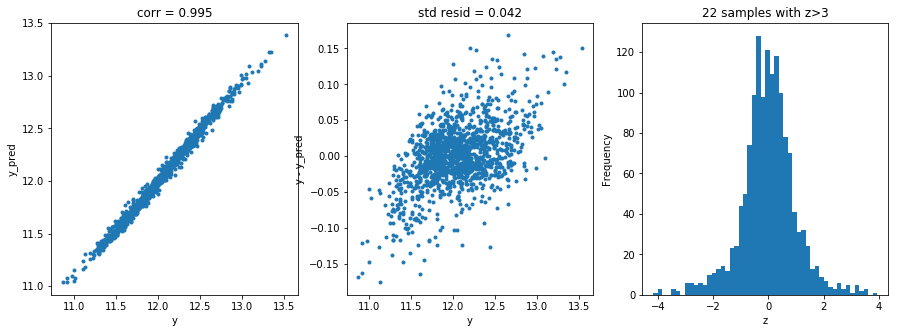

In [44]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

### Gradient Boosting

In [45]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[100,175,250],
              'max_depth':[2,3,4],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  3.1min finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=250, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
----------------------
score= 0.991635860472
rmse= 0.0363502253963
cross_val: mean= 0.122477661386 , std= 0.0105682862789


### XGBoost

In [46]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.9min finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------
score= 0.970108815228
rmse= 0.0681709922013
cross_val: mean= 0.112084725815 , std= 0.00723193142544


## PCA then Ridge with 2nd Order Terms

Fitting 25 folds for each of 19 candidates, totalling 475 fits


[Parallel(n_jobs=1)]: Done 475 out of 475 | elapsed:  1.8min finished


----------------------
Ridge(alpha=65, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.98154258656
rmse= 0.0528813428507
cross_val: mean= 0.100052124908 , std= 0.00600928913678


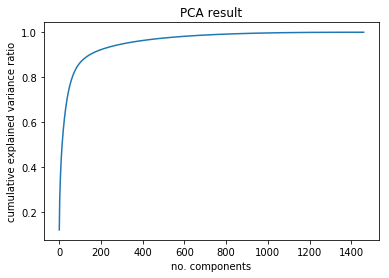

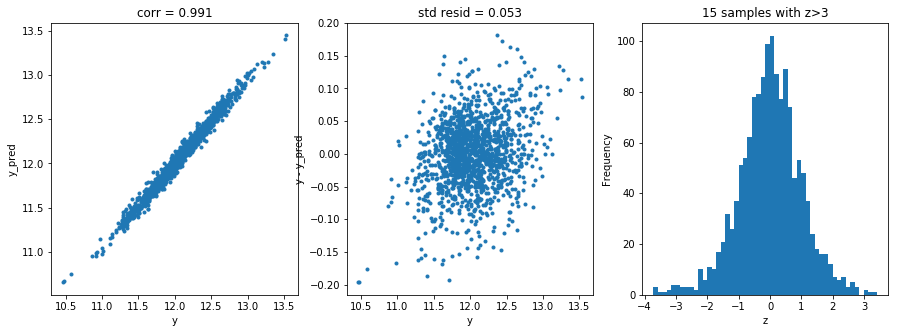

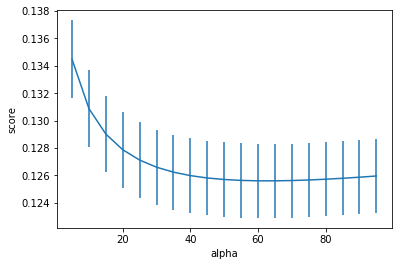

In [47]:
model = 'PolyPCA'

X,y=get_training_data()

# get 2nd order terms
poly = PolynomialFeatures()
X = poly.fit_transform(X,y)

# reduce dimensionality using PCA
# n_components = len(X) by default
# (as no. polynomial features >> len(x))
pca = PCA()
X = pca.fit_transform(X,y)
X = pd.DataFrame(X,index=y.index)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no. components')
plt.ylabel('cumulative explained variance ratio')
plt.title('PCA result')

alph_range = np.arange(5,100,5)
param_grid = {'alpha':alph_range}
ridge, cv_score, grid_results = train_model(Ridge(),X=X,y=y,param_grid=param_grid)

cv_score.name = model
score_models = score_models.append(cv_score)

# combine results in to a pipeline
opt_models[model] = Pipeline([('Poly',poly),('PCA',pca),('Ridge',ridge)])

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

## Compare Models

mean       std
Lasso             0.094718  0.004911
Ridge             0.098014  0.004490
PolyPCA           0.100052  0.006009
LinearSVR         0.103040  0.006728
SVR               0.104878  0.003972
XGB               0.112085  0.007232
RandomForest      0.115802  0.003491
GradientBoosting  0.122478  0.010568
KNeighbors        0.177605  0.009592
ElasticNet        0.201649  0.008362

Ridge     Lasso  ElasticNet  LinearSVR       SVR  \
Ridge             1.000000  0.996841    0.899862   0.990680  0.996831   
Lasso             0.996841  1.000000    0.901754   0.988591  0.993814   
ElasticNet        0.899862  0.901754    1.000000   0.883233  0.901184   
LinearSVR         0.990680  0.988591    0.883233   1.000000  0.985251   
SVR               0.996831  0.993814    0.901184   0.985251  1.000000   
KNeighbors        0.936963  0.934408    0.915363   0.924441  0.939364   
RandomForest      0.981859  0.981517    0.897115   0.974942  0.984184   
GradientBoosting  0.971710  0.970954    0.872140   0.966585  0.973336   
XGB               0.979981  0.980743    0.884590   0.974077  0.979396   
PolyPCA           0.993751  0.990770    0.891666   0.986119  0.994868   

                  KNeighbors  RandomForest  GradientBoosting       XGB  \
Ridge               0.936963      0.981859          0.971710  0.979981   
Lasso               0.934408      0.981517          0.970954  0.980743   
ElasticNet          0.915363      0.897115          0.872140  0.884590   
LinearSVR           0.924441      0.974942          0.966585  0.974077   
SVR                 0.939364      0.984184          0.973336  0.979396   
KNeighbors          1.000000      0.940166          0.917198  0.920659   
RandomForest        0.940166      1.000000          0.979198  0.980623   
GradientBoosting    0.917198      0.979198          1.000000  0.990293   
XGB                 0.920659      0.980623          0.990293  1.000000   
PolyPCA             0.936467      0.988433          0.979367  0.981778   

                   PolyPCA  
Ridge             0.993751  
Lasso             0.990770  
ElasticNet        0.891666  
LinearSVR         0.986119  
SVR               0.994868  
KNeighbors        0.936467  
RandomForest      0.988433  
GradientBoosting  0.979367  
XGB               0.981778  
PolyPCA           1.000000

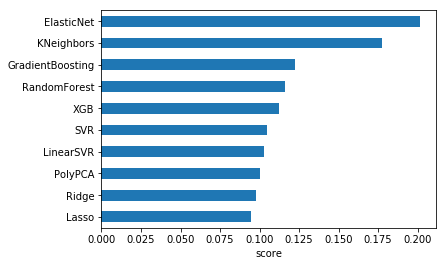

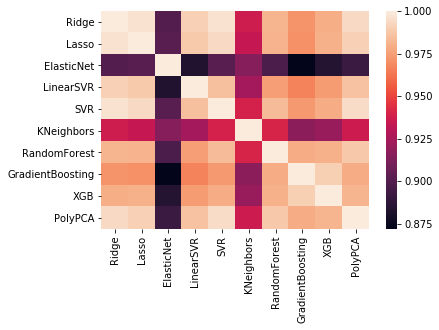

In [48]:
X,y = get_training_data()

Y_models = pd.DataFrame(index=y.index)    

for key, model in opt_models.items():
    Y_models[key] = model.predict(X)

corr_models = pd.DataFrame(Y_models).corr()

score_models = score_models.sort_values(by='mean')

display(score_models)
score_models['mean'].plot.barh()
plt.xlabel('score')

plt.figure()
display(corr_models)
sns.heatmap(corr_models)

## Predict SalePrice for the Test Data

In [49]:
def predict_test(model):
    # get test data
    X_test = get_test_data()

    # predict SalePrices
    y_test = model.predict(X_test)

    #revert log transformation
    y_test = np.exp(y_test)-1

    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test

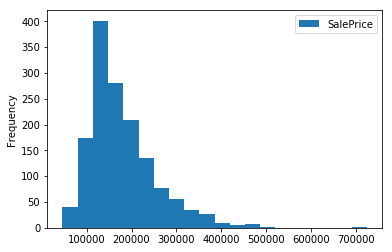

In [50]:
y_test = predict_test(opt_models['Lasso'])

y_test.plot.hist(bins=20)

# make submission file
y_test.to_csv('submission.csv')

### Ensemble Model

Not found an approach that gives a score improvement over just Lasso.

Lasso        0.222682
Ridge        0.207958
PolyPCA      0.199570
LinearSVR    0.188165
SVR          0.181626
Name: mean, dtype: float64


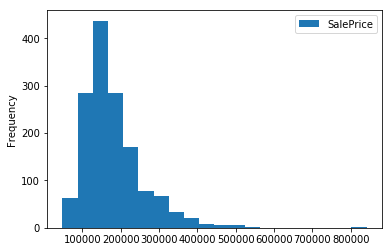

In [51]:
# weights to try in an ensemble model:
# 1/score^2 normalised to sum to 1
def model_weights(models):
    weights = 1/(score_models.loc[models,'mean']**2)
    weights = weights/sum(weights)
    return weights

# predict a SalePrice using multiple models
def predict_ensemble(models):
    # get test data
    X_test = get_test_data()
   
    # predict SalePrice for each model
    Y_models = pd.DataFrame(index=X_test.index)    
    for model in models:
        Y_models[model] = opt_models[model].predict(X_test)

    # get weights for each model
    weights = model_weights(models)
    
    # calculate final prediction
    Y_models = Y_models*weights
    y_test = Y_models.sum(axis=1)

    #revert log transformation
    y_test = np.exp(y_test)-1
    
    # convert to dataframe suitable for creating submission file
    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test

#example with top 5 models
print(model_weights(score_models.iloc[:5].index))
y_test = predict_ensemble(score_models.iloc[:5].index)
y_test.plot.hist(bins=20)

In [52]:
#Think about:
# Outlier removal - may be harmful some cases?

------------------------
140 zero coefficients:
------------------------
['1stFlr', '2ndFlr', 'Alley_Grvl', 'Alley_None', 'BedroomAbvGr', 'BldgType_2fmCon', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtALQ', 'BsmtBLQ', 'BsmtCond', 'BsmtLwQ', 'BsmtRec', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRNe', 'Condition1_RRNn', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'EnclosedPorch', 'ExterCond', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_Other', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None', 'Foundation_CBlock', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'GarageCond', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_None', 'GarageYrBlt', 'Has2ndFlr', 'HasBsmtBLQ', 'HasBsmtUnf'

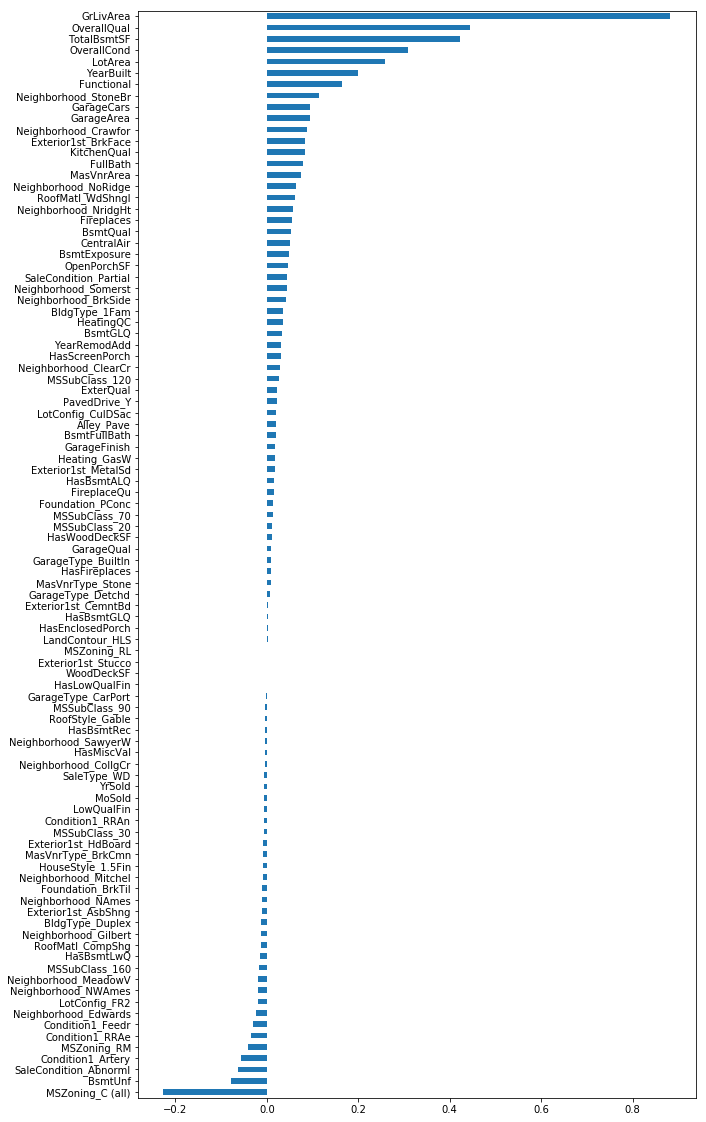

In [53]:
lasso_coefs = pd.Series(opt_models['Lasso'].coef_,index=X.columns).sort_values()
plt.figure(figsize=(10,20))
lasso_coefs[lasso_coefs!=0].plot.barh()
print('------------------------')
print(sum(lasso_coefs==0),'zero coefficients:')
print('------------------------')
print(lasso_coefs[lasso_coefs==0].index.sort_values().tolist())
print('------------------------')
print(sum(lasso_coefs!=0),'non-zero coefficients:')
print('------------------------')